## Need to run:
coevolve python package (currently only installed locally in /data2/isshamie/coevolve/coevolve. Go to that folder and run pip install -e .)

1. parameters folder. The evc template is in there and the parameter file that points to the genome information (in case that changes).  
2. data/raw is the folder that contains that genome files  
3. data/notebook with this file and Covid19 - Alignment and Couplings Output.ipynb

### Parameter file (should be in parameters folder)

In [1]:
main_dir = "../"
param = 'sars_cov2.yaml'

### 0.1 Import 

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
from Bio import SeqIO, Seq, pairwise2, SeqRecord, Align
from os.path import join, basename
import pickle
import numpy as np
from tqdm import tqdm
from numpanpar import parallel_ar as parar
import seaborn as sns

%load_ext autoreload
%autoreload 2

/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from config import FIGURES_DIR, ROOT_DIR, PARAMS_DIR, RESULTS, CONTACT_FIGURES_DIR, NUM_CORES
from coevolve.msa import clustalw_query, msa_stats
from coevolve.config import CLUSTALW_DIR, CLUSTALW_CMD, CLUSTALW_CLEAN_DIR
from evcouplings.utils import read_config_file, write_config_file
from coevolve.couplings.running_jobs_complexes import run_evc
from coevolve.couplings.couplings_vis import construct_monomer_contact_matrix
from coevolve.data.data_io import read_msa


Project Directory: /data2/isshamie/covid/covid_03302020

Config paths:
__name__ config
__package__ 
__file__ /data2/isshamie/covid/covid_03302020/notebook/config.py
__cached__ /data2/isshamie/covid/covid_03302020/notebook/__pycache__/config.cpython-37.pyc
path /data2/isshamie/covid/covid_03302020/notebook/config.py
DATA_DIR /data2/isshamie/covid/covid_03302020/data
RESULTS /data2/isshamie/covid/covid_03302020/data/processed
FIGURES_DIR /data2/isshamie/covid/covid_03302020/figures
CONTACT_FIGURES_DIR /data2/isshamie/covid/covid_03302020/figures/contact
PAIR_COUPLINGS_FIGURES_DIR /data2/isshamie/covid/covid_03302020/figures/pair_couplings
GLYCO_PAIR_COUPLINGS_FIGURES_DIR /data2/isshamie/covid/covid_03302020/figures/glycosites_pair_couplings
PARAMS_DIR /data2/isshamie/covid/covid_03302020/parameters
d /data2/isshamie/covid/covid_03302020/figures/glycosites_pair_couplings
UNIPROT_MAP /data2/isshamie/covid/covid_03302020/data/external/biomart/mart_export_uniprot.txt
GENE_MAP /data2/isshamie

### Setup folders and files

In [4]:
RAW = join(main_dir,"data","raw")
outdir = join(main_dir,"data","processed")


seqs_dir = join(outdir,"seqs")
align_dir = join(seqs_dir,"S_protein_align")
align_concat_dir = join(seqs_dir,"S_protein_align_full")
msa_out = join(outdir, "msa")
anno_f = join(outdir, "covid_annotations.csv")
ev_dir = join(outdir,"evc")
contact_dir = join(outdir, "contact")
ev_params_dir = join(outdir,"ev_params")
evzoom_dir = join(outdir,"evzoom")
evzoom_template_dir = join(ROOT_DIR, "software", "EVzoom")
param_dir = join(main_dir,"parameters")
evc_template_f = join(param_dir,'evc',"template.yaml")

msa_f = join(msa_out,"S_protein.msa.fasta")
if not os.path.exists(msa_out):
    os.mkdir(msa_out)
anno_f = join(seqs_dir, "covid_annotations.csv")
clean = join(msa_out,"clean")
if not os.path.exists(clean):
    os.mkdir(clean)

#clustalw_query.create_clean_clustalw_names(clean, [msa_f])

msa_clean_f = join(clean, os.path.basename(msa_f))

NUM_CORES = 32


## 1. Load:
- A) Genomic fasta sequences, 
- B) Reference Genomic Annotation (GCF_009858895.2)
- C) Reference Gene Annotation (NC_045512.2)
- D) S-protein fasta protein sequence

In [5]:
config = read_config_file(join(param_dir, param))
config

{'name': 'sars_cov2',
 'ref_fasta': 'NC_045512.2.fasta',
 'genomes_fasta': '2020-03-30-gisaid-seqs.fasta',
 'S_protein_name': 'YP_009724390.1',
 'annotation': 'GCF_009858895.2_ASM985889v3_genomic.gff'}

## MSA Out

In [6]:
msa = read_msa(msa_clean_f)

print(f"MSA sequences shape (N organisms-by-L sequences: {msa.shape}")

MSA sequences shape (N organisms-by-L sequences: (2469, 9464)


In [7]:
msa_stats = msa_stats.wrap_calc_msa_stats(os.path.dirname(msa_f), num_cores=1)
msa_stats

New pandarallel memory created - Size: 2000 MB
Pandarallel will run on 1 workers
../data/processed/msa/S_protein.msa.fasta


/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/pyarrow/serialization.py:165: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(obj, pd.SparseDataFrame):


../data/processed/msa/S_protein.msa.fasta


/home/isshamie/software/anaconda2/envs/coevolve/lib/python3.7/site-packages/pyarrow/serialization.py:165: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(obj, pd.SparseDataFrame):


                                           MSA Length  \
../data/processed/msa/S_protein.msa.fasta        9464   

                                           Median Percent of Gaps per Homolog  \
../data/processed/msa/S_protein.msa.fasta                           86.549028   

                                           Variance Percent of Gaps per Homolog  \
../data/processed/msa/S_protein.msa.fasta                              12.10262   

                                           Median Percent of Non-gaps Per Residue Position  \
../data/processed/msa/S_protein.msa.fasta                                          0.72904   

                                           Number of Residues with >50% Nongaps  \
../data/processed/msa/S_protein.msa.fasta                                  1273   

                                                                             Percent nongaps  
../data/processed/msa/S_protein.msa.fasta  [0.04050222762251924, 0.04050222762251924, 0.0...  


,MSA Length,Median Percent of Gaps per Homolog,Variance Percent of Gaps per Homolog,Median Percent of Non-gaps Per Residue Position,Number of Residues with >50% Nongaps,Percent nongaps
../data/processed/msa/S_protein.msa.fasta,9464,86.549028,12.10262,0.72904,1273,"[0.04050222762251924, 0.04050222762251924, 0.0..."


## EVCouplings out:

In [8]:
ev_out_dirs = list(filter(lambda x: os.path.isdir(x), glob.glob(ev_dir+"/*")))
for curr_ev in ev_out_dirs:
    name = basename(curr_ev)
    ev_msa = read_msa(join(curr_ev, "align", name+".a2m"))

In [9]:
print(f"Final sequences shape (N organisms-by-L sequences: {ev_msa.shape[0]}")

Final sequences shape (N organisms-by-L sequences: 2469


In [10]:
%matplotlib inline

Number of columns with no gaps at all:0


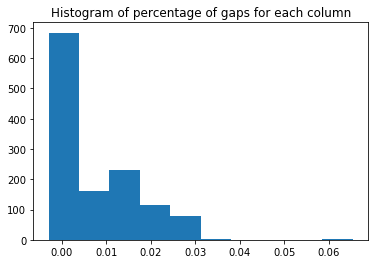

In [11]:
f = plt.figure()
plt.hist(((ev_msa == "-").sum(axis=0))/ev_msa.shape[0], align='left');
plt.title("Histogram of percentage of gaps for each column")
print(f"Number of columns with no gaps at all:{((ev_msa == '-').sum(axis=0)==0).sum()}")


Number of sequences with no gaps at all:2231
Number of sequences with >0 gaps :238


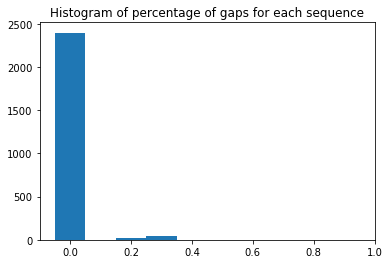

In [12]:

f = plt.figure()
plt.hist(((ev_msa == "-").sum(axis=1))/ev_msa.shape[1], align='left');
plt.title("Histogram of percentage of gaps for each sequence")
print(f"Number of sequences with no gaps at all:{((ev_msa == '-').sum(axis=1)==0).sum()}")
print(f"Number of sequences with >0 gaps :{((ev_msa == '-').sum(axis=1)>0).sum()}")